In [1]:
import ipywidgets as W
L = W.Layout
print("tested with ipywidgets (7, 6, 5, 'final', 0), current version ipywidgets is:" ,W.version_info)

tested with ipywidgets (7, 6, 5, 'final', 0), current version ipywidgets is: (7, 6, 5, 'final', 0)


<h1> Wrap W Ouptut() to add notification when output goes to not empty </h1>
<p> 
We poll to see if something was added.  We also check if something had been added since the last time we polled before clearing the output.  Hence as long as the output is conly cleared by calling the child clear_output we will not miss an empty to not empty transition.
 </p>

In [2]:
import asyncio
from threading import Thread

In [3]:
class Output(W.Output):
  def __init__(self ,*args):
    super().__init__(*args)
    self.was_empty = True
    self.on_became_not_empty_fs = []
    self.interval = 1
    self.check_became_not_empty_loop_task = asyncio.create_task(self._check_became_not_empty_loop())
    
  def __del__(self):
    self.check_became_not_empty_loop_task.cancel()
    
  def _check_became_not_empty(self):
    now_empty = self.empty()
    if not now_empty and self.was_empty:
      for f in self.on_became_not_empty_fs: 
        thread = Thread(target=f)
        thread.start()
    self.was_empty = now_empty
      
  # asyncio uses green threads, so using threads here doesn't accmplish much.  It does make the sleep timer for loop delay more accurate.
  async def _check_became_not_empty_loop(self):
    while True: 
      self._check_became_not_empty()
      await asyncio.sleep(self.interval)   
        
  def empty(self):
    return len(self.outputs) == 0 

  def on_became_not_empty(self ,f):
    self.on_became_not_empty_fs.append(f)
    
  def clear_output(self):
    self._check_became_not_empty() # it might have happened since we last polled
    self.was_empty = True
    super().clear_output()

<h3> test 0 </h3>

In [4]:
s0 = W.Output()

In [5]:
display(s0)

Output()

In [6]:
s1 = Output()

In [7]:
display(s1)

Output()

In [8]:
def f():
  s0.append_stdout("transition to not empty")
  s0.append_stdout("\n")

In [9]:
s1.on_became_not_empty(f)

In [10]:
with s1: print("s1")  # upon entering this line the message of ‘transition to not empty’ should appear in s0 display

In [11]:
s1.clear_output()  # clear the output and add more text, the message should appear again

In [12]:
with s1: print("s1 again")  

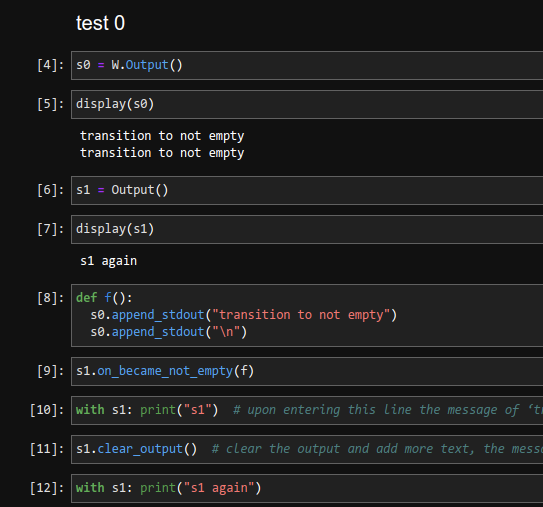